In [1]:
#필요한 모드 임포트
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [2]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list
plt.rcParams['font.family'] = 'GULIM'

In [3]:
#이미지 파일경로 저장 및 데이터 라벨링
# dir_ = Path('/Users/minsu/Desktop/ValidationDataSet/Dog/Common')
dir_ = Path('E:\PetData\Data\Validation\LabelingData\VL\Dog')
filepaths = list(dir_.glob(r'**/*.jpg'))
print(len(filepaths))
print(str(filepaths[600]))
print(str(filepaths[600]).split("\\")[-3])
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("\\")[-3] \
              for i in range(len(filepath))]
    
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    print(labels)

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

22041
E:\PetData\Data\Validation\LabelingData\VL\Dog\Eye\sonogramOfEye\cataract\None\crop_D45_beb6c05d-63a6-11ec-b317-0a7404972c70.jpg
cataract
0        cataract
1        cataract
2        cataract
3        cataract
4        cataract
           ...   
22036         핵경화
22037         핵경화
22038         핵경화
22039         핵경화
22040         핵경화
Name: Label, Length: 22041, dtype: object


,Filepath,Label
0,E:\PetData\Data\Validation\LabelingData\VL\Dog...,백내장
1,E:\PetData\Data\Validation\LabelingData\VL\Dog...,궤양성각막질환
2,E:\PetData\Data\Validation\LabelingData\VL\Dog...,비궤양성각막질환
3,E:\PetData\Data\Validation\LabelingData\VL\Dog...,색소침착성각막염
4,E:\PetData\Data\Validation\LabelingData\VL\Dog...,백내장


In [4]:
#데이터 라벨링된 결과
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 22041

Number of different labels: 12

Labels: ['백내장' '궤양성각막질환' '비궤양성각막질환' '색소침착성각막염' '안검내반증' '핵경화' '유루증' '유리체변성' '안검염'
 '결막염' 'cataract' '안검종양']


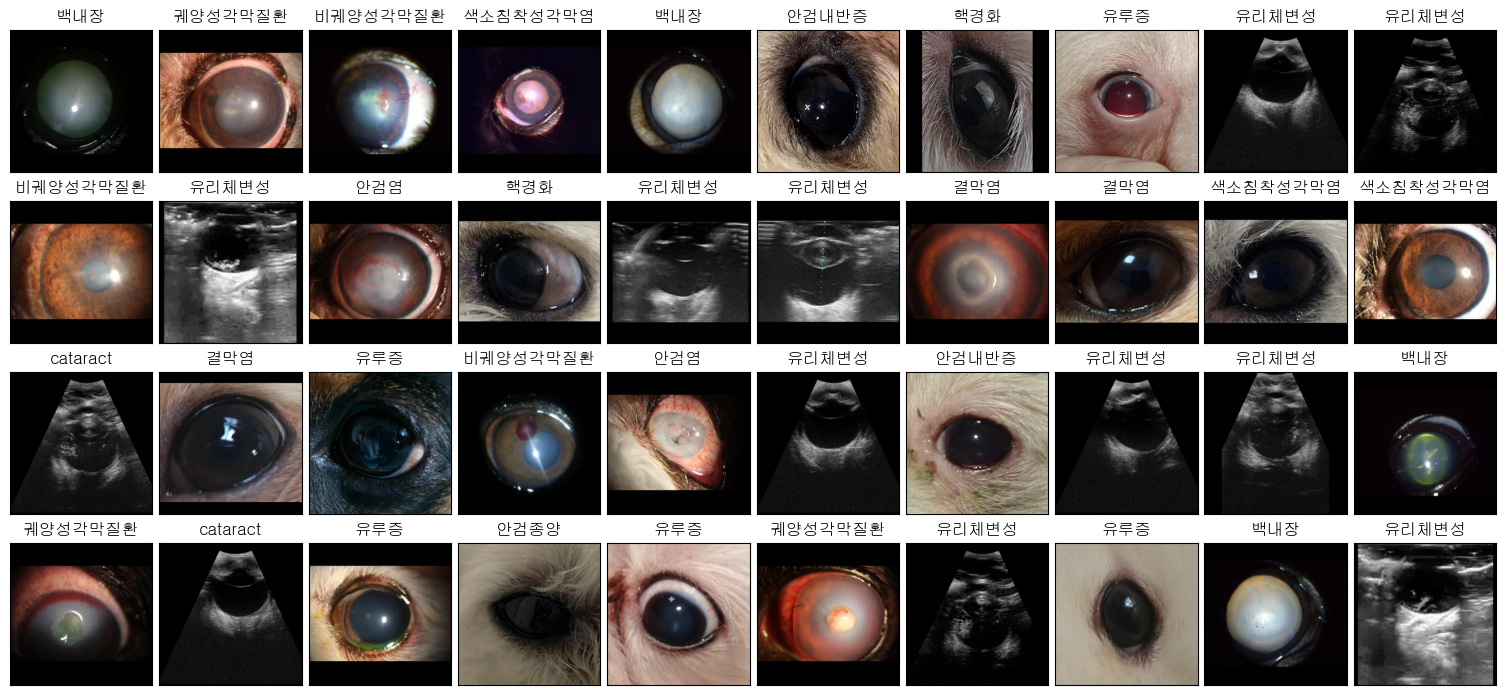

In [5]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [6]:
idx = df[df['Label'] == "Dog"].index
df.drop(idx , inplace=True)

In [7]:
idx = df[df['Label'] == "Common"].index
df.drop(idx , inplace=True)

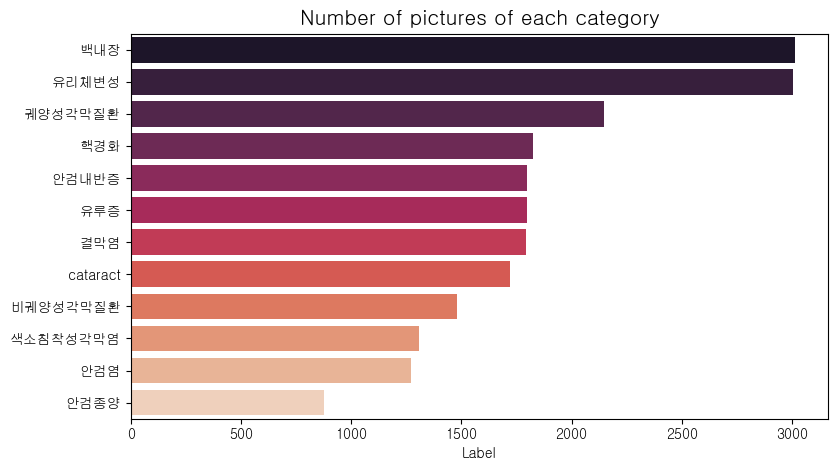

In [8]:
#다이어그램으로 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc, y = vc.index, palette = "rocket",orient='h')
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [9]:
#테스트 셋 연습 셋 확인
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((19836, 2), (2205, 2))

In [10]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('E:\PetData\Data\Validation\LabelingData\VL\Dog',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('E:\PetData\Data\Validation\LabelingData\VL\Dog',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 21428 images belonging to 1 classes.
Found 5356 images belonging to 1 classes.


In [11]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [14]:
#데이터셋을 가지고 모델 전이 학습
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201) #위 결과에서 가장 좋은 성과를 낸 모델을 사용
history = model.fit(train_images,validation_data=val_images,epochs=15)

Found 17853 validated image filenames belonging to 12 classes.
Found 1983 validated image filenames belonging to 12 classes.
Found 2205 validated image filenames belonging to 12 classes.
Epoch 1/15
558/558 [==============================] - 1378s 2s/step - loss: 1.2851 - accuracy: 0.4815 - val_loss: 1.1342 - val_accuracy: 0.5315
Epoch 2/15
558/558 [==============================] - 1392s 2s/step - loss: 1.0904 - accuracy: 0.5384 - val_loss: 1.0518 - val_accuracy: 0.5633
Epoch 3/15
558/558 [==============================] - 1379s 2s/step - loss: 1.0220 - accuracy: 0.5599 - val_loss: 1.0314 - val_accuracy: 0.5587
Epoch 4/15
558/558 [==============================] - 1382s 2s/step - loss: 0.9592 - accuracy: 0.5865 - val_loss: 1.0213 - val_accuracy: 0.5436
Epoch 5/15
558/558 [==============================] - 1373s 2s/step - loss: 0.9189 - accuracy: 0.6012 - val_loss: 0.9893 - val_accuracy: 0.5784
Epoch 6/15
558/558 [==============================] - 1282s 2s/step - loss: 0.8772 - accuracy

In [15]:
model.save('petEyeDiagnosis.h5')

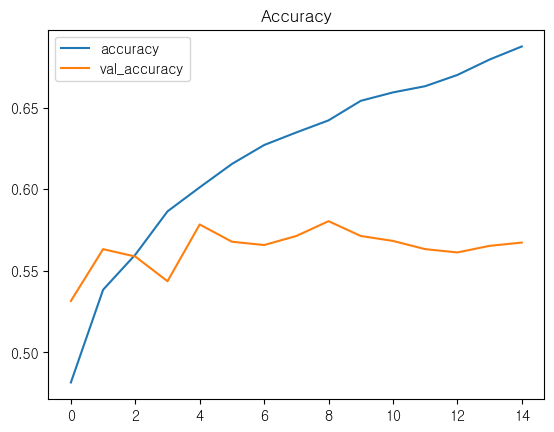

In [16]:
#정확도
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

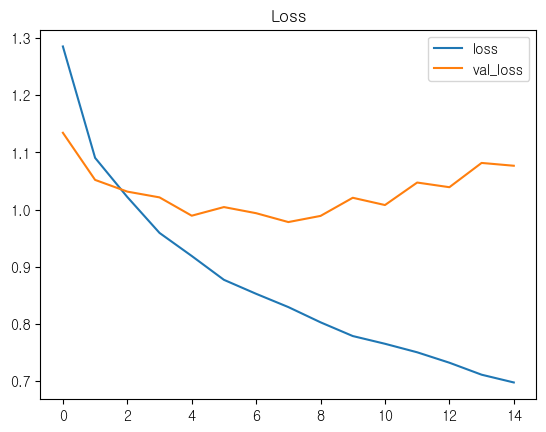

In [17]:
#손실도
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

번호를 입력하세요 : 1282


## 예측률 : 88.27%

9


### Class prediction = NuclearSclerosis

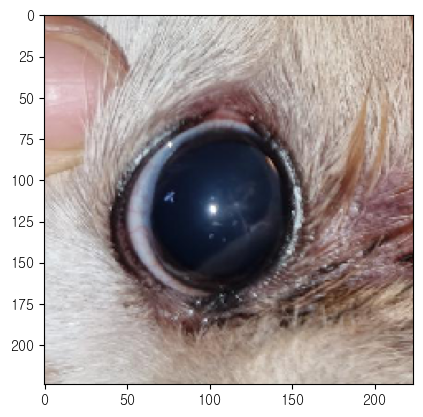

In [22]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'Blepharitis': 0,
                    'Cataract':1,
                    'Conjunctivitis':2,
                    'CornealUlcerative':3,
                    'Entropion':4,
                    'Epiphora':5,
                    'EyelidTumor':6,
                    'NoneCornealUlcerative':7,
                    'NoneExistence':8,
                    'NuclearSclerosis':9,
                    'PigmentedKeratitis':10,
                   }
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    print(df[df == df.iloc[0]].index[0])
    printmd(f"### Class prediction = {x}")
    break

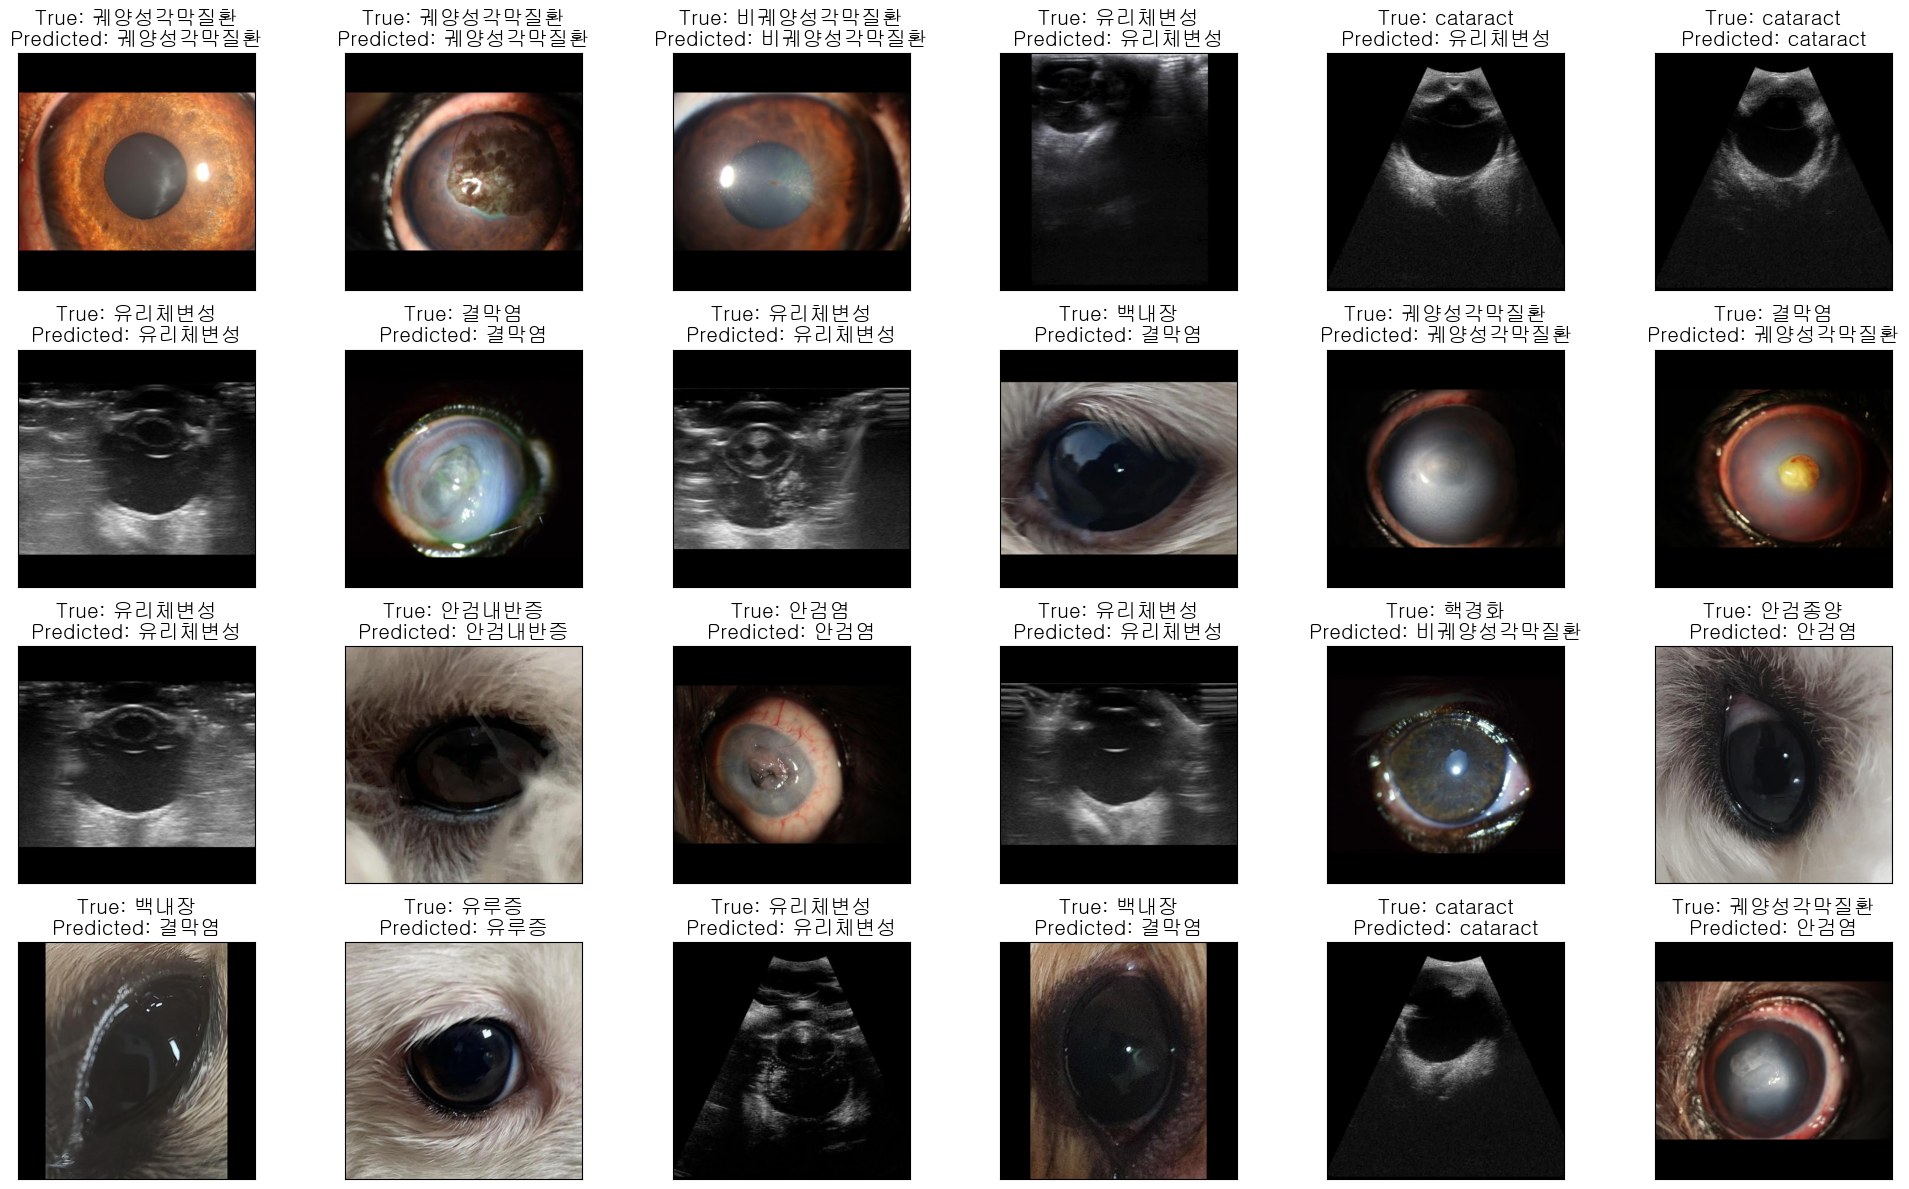

In [23]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()